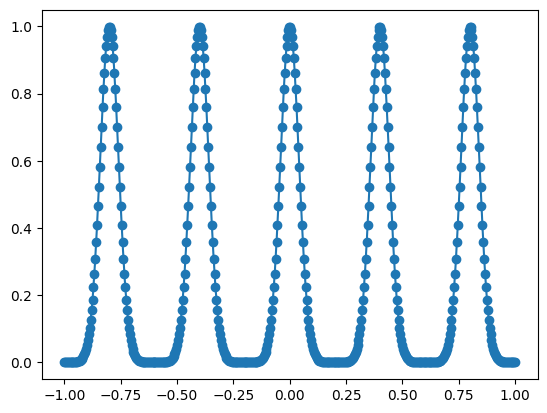

In [202]:
from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt

datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)

x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)


y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)

y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)


plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

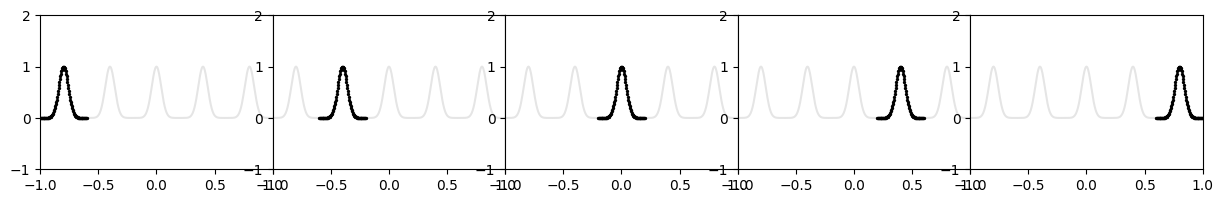

In [203]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)

In [204]:
ys = []

# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model_kan = KAN(width=[1,1], grid=200, k=3, noise_scale=0.1, sp_trainable=False, sb_trainable=False, base_fun='zero')

for group_id in range(n_peak):
    dataset = {}
    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    model_kan.fit(dataset, opt = 'LBFGS', steps=100, update_grid=False);
    y_pred = model_kan(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])



checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:00<00:00, 107.4


saving model version 0.1


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:01<00:00, 98.33


saving model version 0.2


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:00<00:00, 114.5


saving model version 0.3


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:00<00:00, 114.2


saving model version 0.4


| train_loss: 3.99e-06 | test_loss: 3.99e-06 | reg: 3.31e+00 | : 100%|█| 100/100 [00:01<00:00, 99.30


saving model version 0.5


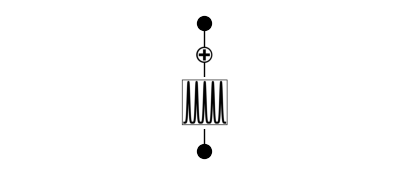

In [205]:
model_kan.plot()

saving model version 0.6


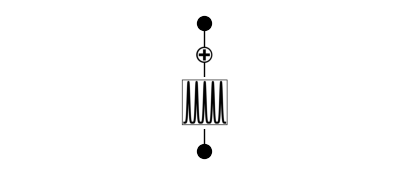

In [206]:
model_kan.auto_swap()
model_kan.plot()

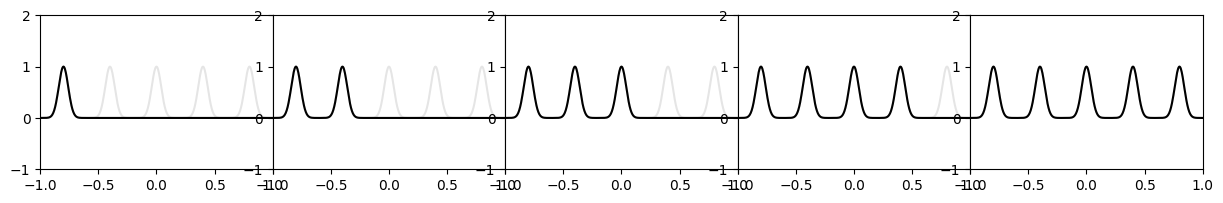

In [207]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
    plt.xlim(-1,1)
    plt.ylim(-1,2)

In [208]:
from kan.MLP import MLP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We use [1, 128, 1] because an MLP needs hidden neurons to fit non-linearities.
# A [1, 1] MLP is just a linear regressor.
# 128, 256, 512
#model_mlp = MLP(width=[1, 128, 256, 128, 1], seed=5, device=device)
model_mlp = MLP(width=[1, 66, 1], seed=8, device=device)


ys_mlp = []

# --- 4. Sequential Training Loop ---
print("Starting sequential training on MLP...")

for group_id in range(n_peak):
    dataset = {}

    # Slice the data for the current peak (current group)
    train_input = x_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak][:, None]
    train_label = y_sample[group_id * n_num_per_peak:(group_id + 1) * n_num_per_peak][:, None]

    # Move to device
    dataset['train_input'] = train_input.to(device)
    dataset['train_label'] = train_label.to(device)
    dataset['test_input'] = train_input.to(device)
    dataset['test_label'] = train_label.to(device)
    model_mlp.fit(dataset, opt='LBFGS', steps=100, lamb=0.0)

    x_grid_device = x_grid[:, None].to(device)
    y_pred = model_mlp(x_grid_device)
    ys_mlp.append(y_pred.detach().cpu().numpy()[:, 0])

Starting sequential training on MLP...


| train_loss: 4.24e-02 | test_loss: 4.24e-02 | reg: 4.08e+02 | : 100%|█| 100/100 [00:00<00:00, 142.6
| train_loss: 1.58e-01 | test_loss: 1.58e-01 | reg: 5.60e+02 | : 100%|█| 100/100 [00:00<00:00, 172.1
| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 6.08e+02 | : 100%|█| 100/100 [00:00<00:00, 143.4
| train_loss: 1.14e-01 | test_loss: 1.14e-01 | reg: 6.11e+02 | : 100%|█| 100/100 [00:00<00:00, 131.7
| train_loss: 6.18e-02 | test_loss: 6.18e-02 | reg: 5.57e+02 | : 100%|█| 100/100 [00:00<00:00, 171.5


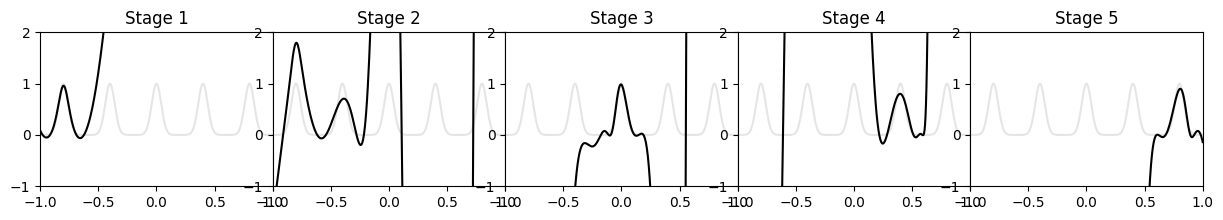

In [209]:
# --- 5. Final Plotting (Same format as KAN example) ---
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1, 6):
    plt.subplot(1, 5, i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys_mlp[i - 1], color='black')

    plt.xlim(-1, 1)
    plt.ylim(-1, 2)
    plt.title(f"Stage {i}")

plt.show()

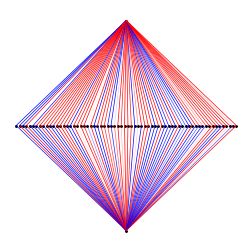

In [210]:
model_mlp.plot()